In [1]:
# DO NOT CHANGE

import torch
from PIL import Image
from IPython import display

import pandas as pd
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Image tensor on device:
---------------
cuda:0

Inputs information:
---------------
shape:torch.Size([1, 3, 224, 224])
class: <class 'torch.Tensor'>

Shape of outputs:
---------------
torch.Size([1, 1000])

Pred Index:
---------------
235

Pred Label:
---------------
German shepherd



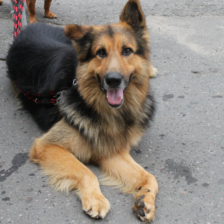

In [16]:
# DO NOT CHANGE

#load the model from the pytorch hub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT', verbose=False)

# Put model in evaluation mode
model.eval()

# put the model on a GPU if available, otherwise CPU
model.to(device);

# Define the transforms for preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop the image to 224x224 about the center
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize the image with the ImageNet dataset mean values
        std=[0.229, 0.224, 0.225]  # Normalize the image with the ImageNet dataset standard deviation values
    )
]);

unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

with open("../data/labels.txt", 'r') as f:
    labels = [label.strip() for label in f.readlines()]

img = Image.open("../data/dog.jpg")
img_tensor = preprocess(img).unsqueeze(0)
img_tensor = img_tensor.to(device)

with torch.no_grad():
    output = model(img_tensor)

print(f"Image tensor on device:\n---------------\n{img_tensor.device}\n")
print(f"Inputs information:\n---------------\nshape:{img_tensor.shape}\nclass: {type(img_tensor)}\n")
print(f"Shape of outputs:\n---------------\n{output.shape}\n")
print(f"Pred Index:\n---------------\n{output[0].argmax()}\n")
print(f"Pred Label:\n---------------\n{labels[output[0].argmax()]}\n")

unnormed_img_tensor= unnormalize(img_tensor)

img_pil = transforms.functional.to_pil_image(unnormed_img_tensor[0])
img_pil.show()

In [17]:
img_tensor = preprocess(img).unsqueeze(0).to(device)

In [18]:
# generate random masks
n_masks = 3000
eta = 0.005

mask_collection = torch.randn((n_masks, *img_tensor.shape)).to(device)*eta

current_mask = torch.zeros_like(img_tensor).to(device)

In [19]:
# provided code
target_index = torch.tensor(labels.index('robin')).unsqueeze(0).to(device)
print(f"Target index is:\n---------------\n{target_index}\n")

target_class_score = model(img_tensor + current_mask)[0, target_index.item()].item()
print(f"Target class score is:\n---------------\n{target_class_score}\n")

n_masks = 3000
eta = 0.01

mask_collection = torch.randn((n_masks, *img_tensor.shape)).to(device)*eta
current_mask = torch.zeros_like(img_tensor).to(device)

# Get our starting label index
starting_label = model(img_tensor).argmax(1).item()
current_label = starting_label

# Get our starting confidence score
best_score = model(img_tensor + current_mask)[0, target_index.item()].item()

# Run until we reclassify successfully ...
while current_label != target_index:

    # Select a random mask from the collection we created
    mask_candidate_idx = np.random.choice(len(mask_collection))
    mask_candidate = mask_collection[mask_candidate_idx]

    # Don't store gradient information while doing inference
    with torch.no_grad():
        # get the scores for the image if we updated the current mask to
        # use the candidate we just randomly picked
        output = model(img_tensor + current_mask + mask_candidate)
    
    # select the most probable label from the output of the model with the candidate mask in play
    current_label = output.argmax(1).item()
    # our score will be the score of our original label: we want this to go _down_ (i.e. the current
    # label to become less likely)
    new_score = output[0, target_index.item()].item()

    # If the score for the current class -- the one we're trying to get away from -- did not decrease, then
    # skip back to the beginning and pick another candidate mask
    if new_score < best_score:
        continue
   
    # Write some monitoring for dopamine 
    print(f"Best score is: {best_score:4.6f} -- prediction is: {current_label}  ", end='\r', flush=True)
    
    # Update our current score
    best_score = new_score
    
    # And update our mask
    current_mask += mask_candidate
                
print(f"\n\nWinner winner: {labels[output[0].argmax()]} ({output[0].argmax()})")

Target index is:
---------------
tensor([15], device='cuda:0')

Target class score is:
---------------
-0.8352328538894653

Best score is: 5.577676 -- prediction is: 235   

Winner winner: robin (15)
